In [787]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [788]:
# Load the two images (both should be in grayscale for SIFT)
pano_img1 = cv2.imread('pano_image1.jpg', cv2.IMREAD_GRAYSCALE)
pano_img2 = cv2.imread('pano_image2.jpg', cv2.IMREAD_GRAYSCALE)

# Check if images loaded properly
if pano_img1 is None or pano_img2 is None:
    raise ValueError("Error: One or both images could not be loaded. Check the file paths.")

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(pano_img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(pano_img2, None)

# You can visualize keypoints if you want (optional)
# img1_kp = cv2.drawKeypoints(pano_img1, keypoints1, None)
# img2_kp = cv2.drawKeypoints(pano_img2, keypoints2, None)
# cv2.imshow("Keypoints 1", img1_kp)
# cv2.imshow("Keypoints 2", img2_kp)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [789]:
#brute force matcher takes every descriptor in img and compares it to every descriptor in the other img and returns the best match
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)#k=2 means it will return the 2 best matches for each descriptor
#y3ni lkol descriptor fe img1 2 matches fe img2
#matches is a list of lists

# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if (m.distance/n.distance) < 0.75:
        good_matches.append(m)

#Take the top 50 good matches
good_matches = sorted(good_matches, key=lambda x: x.distance)[:50]


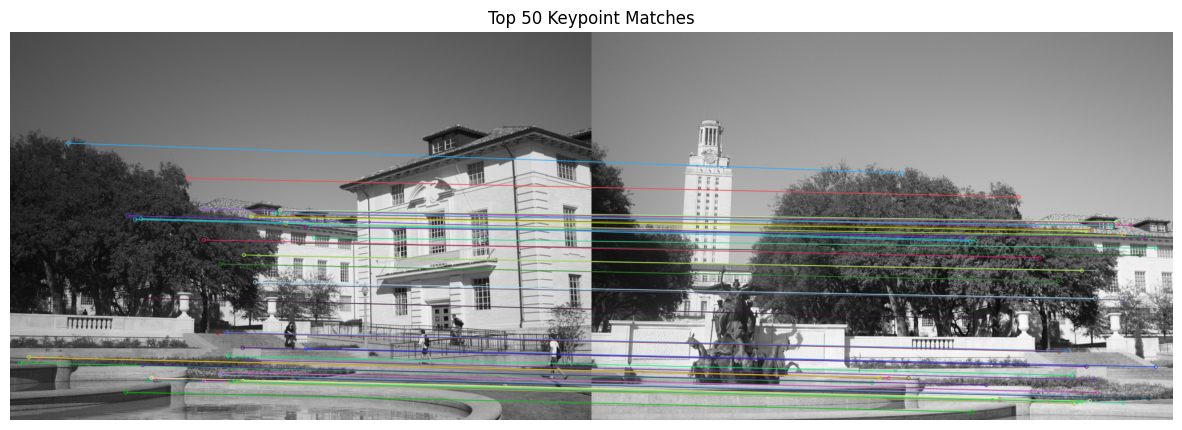

In [790]:
matched_img = cv2.drawMatches(pano_img1, keypoints1, pano_img2, keypoints2, good_matches, None, flags=2)

plt.figure(figsize=(15, 10))
plt.imshow(matched_img, cmap='gray')
plt.title("Top 50 Keypoint Matches")
plt.axis('off')
plt.show()

In [791]:
def compute_homography(src_pts, dst_pts):
    
    #src_pts: List or array of (x, y) points in the first image
    #dst_pts: Corresponding list or array of (x', y') points in the second image

    if len(src_pts) < 4:
        raise ValueError("Need at least 4 point correspondences.")

    A = []
    for (x, y), (x_prime, y_prime) in zip(src_pts, dst_pts):
        A.append([x, y, 1, 0, 0, 0, -x * x_prime, -y * x_prime])
        A.append([0, 0, 0, x, y, 1, -x * y_prime, -y * y_prime])

    A = np.array(A)
    b = np.array(dst_pts).reshape(-1)# Flatten the dst_pts array to make it a 1D array
    # print("A shape:", A.shape)
    # print("b shape:", b.shape)
    # Solve Ah = b
    h = np.linalg.lstsq(A, b, rcond=None)[0]# Get the least-squares solution
    #print("Homography coefficients:", h)

    H = np.append(h, 1).reshape((3, 3))#make h33 = 1 and reshape it to 3x3 matrix
    return H


def apply_homography(H, points):
    #Apply the homography matrix to the points.

    points_hom = np.hstack([points, np.ones((len(points), 1))])  # Convert to homogeneous coordinates [x y 1]
    transformed = (H @ points_hom.T).T  # Matrix multiplication to apply the homography

    # Convert back to Cartesian coordinates(2D) by dividing by the last coordinate
    transformed /= transformed[:, 2][:, np.newaxis]
    return transformed[:, :2]## Keep only the x and y coordinates

def draw_projected_points(original_img, projected_pts, actual_pts=None, title="Projected Points"):
    """
    Draws the projected points on the image.

    Args:
        original_img: The image on which to draw (e.g., frame from video).
        projected_pts: Points mapped using the homography.
        actual_pts: Optional ground truth points (to compare).
        title: Title of the plot.
    """
    img_display = original_img.copy()
    if len(img_display.shape) == 2:
        img_display = cv2.cvtColor(img_display, cv2.COLOR_GRAY2BGR)

    for pt in projected_pts:
        x, y = int(pt[0]), int(pt[1])
        cv2.circle(img_display, (x, y), 5, (0, 0, 255), -1)  # red dot for projected point

    if actual_pts is not None:
        for pt in actual_pts:
            x, y = int(pt[0]), int(pt[1])
            cv2.circle(img_display, (x, y), 5, (0, 255, 0), 2)  # green circle for actual point

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

In [792]:
def warp_image_with_homography(src_img, H, output_shape=None):
   
    h, w = src_img.shape[:2]

    corners = np.array([
        [0, 0],
        [0, h - 1],
        [w - 1, h - 1],
        [w - 1, 0]
    ], dtype=np.float32)

    warped_corners = apply_homography(H,corners)
    print("warped corners:", warped_corners)
    # Find bounds of the output image
    x_min, y_min = np.floor(np.min(warped_corners, axis=0)).astype(int)
    x_max, y_max = np.ceil(np.max(warped_corners, axis=0)).astype(int)

    width = x_max - x_min
    height = y_max - y_min
    print("width:", width, "height:", height)
    if output_shape is not None:
        height, width = output_shape

    # Build output grid (destination image coordinates)
    print("width:", width, "height:", height)
    
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height)) 
    homog_coords = np.stack([x_coords.ravel(), y_coords.ravel(), np.ones_like(x_coords.ravel())])

    H_inv = np.linalg.inv(H)
    src_coords = H_inv @ homog_coords
    src_coords /= src_coords[2]

    x_src = src_coords[0].reshape((height, width))
    y_src = src_coords[1].reshape((height, width))

    # Warp each channel separately
    if src_img.ndim == 3:
        warped_img = np.zeros((height, width, src_img.shape[2]), dtype=np.uint8)
        for c in range(src_img.shape[2]):
            warped_img[:, :, c] = bilinear_interpolate(src_img[:, :, c], x_src, y_src).astype(np.uint8)

    else:
        warped_img = bilinear_interpolate(src_img, x_src, y_src).astype(np.uint8)

    return warped_img

def create_image_mosaic(image1, image2, H):

    # Canvas size
    warped_image1 = warp_image_with_homography(image1, H)

    h1, w1 = warped_image1.shape[:2]
    h2, w2 = image2.shape[:2]
    mosaic_height = int(1.5* max(h1, h2))
    mosaic_width = int(2 * max(w1, w2))

    offset_x = mosaic_width // 8
    offset_y = mosaic_height // 4

    # Translate homography to shift warp to the center
    translation = np.array([[1, 0, offset_x],
                            [0, 1, offset_y],
                            [0, 0, 1]])
    H_translated = translation @ H

    # Warp image1 using translated homography
    warped_image1 = warp_image_with_homography(image1, H_translated, (mosaic_height, mosaic_width))

    # Create mosaic canvas
    if len(image2.shape) == 2:
        mosaic = np.zeros((mosaic_height, mosaic_width), dtype=np.uint8)
        warped_mask = (warped_image1 > 0)
        mosaic[warped_mask] = warped_image1[warped_mask]
        mosaic[offset_y:offset_y + h2, offset_x:offset_x + w2] = image2
    else:
        mosaic = np.zeros((mosaic_height, mosaic_width, 3), dtype=np.uint8)
        warped_mask = (warped_image1 > 0)

        # Overlay warped image1
        for c in range(3):
            mosaic_channel = mosaic[:, :, c]
            warped_channel = warped_image1[:, :, c]
            mask_channel = warped_mask[:, :, c]
            mosaic_channel[mask_channel] = warped_channel[mask_channel]

        # Paste image2 onto the mosaic
        mosaic[offset_y:offset_y + h2, offset_x:offset_x + w2] = image2

    return mosaic


def bilinear_interpolate(image, x, y):
    h, w = image.shape[:2]
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    x0 = np.clip(x0, 0, w - 1)
    x1 = np.clip(x1, 0, w - 1)
    y0 = np.clip(y0, 0, h - 1)
    y1 = np.clip(y1, 0, h - 1)

    Ia = image[y0, x0]
    Ib = image[y1, x0]
    Ic = image[y0, x1]
    Id = image[y1, x1]

    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    return (Ia * wa + Ib * wb + Ic * wc + Id * wd)

warped corners: [[ 447.03469472   76.66098161]
 [ 484.57460127  712.9697622 ]
 [1652.20422672  735.95992869]
 [1572.36500103  -83.54362522]]
width: 1206 height: 820
width: 1206 height: 820


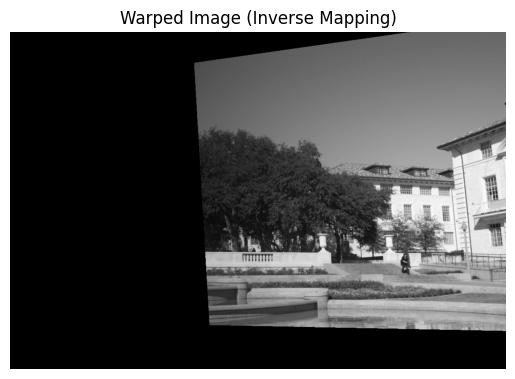

In [793]:
# Get coordinates of good matches
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])


H = compute_homography(src_pts, dst_pts)

warped_image = warp_image_with_homography(pano_img1, H)
plt.imshow(warped_image, cmap='gray')
plt.title("Warped Image (Inverse Mapping)")
plt.axis('off')
plt.show()

warped corners: [[ 447.03469472   76.66098161]
 [ 484.57460127  712.9697622 ]
 [1652.20422672  735.95992869]
 [1572.36500103  -83.54362522]]
width: 1206 height: 820
width: 1206 height: 820
warped corners: [[ 748.03469472  383.66098161]
 [ 785.57460127 1019.9697622 ]
 [1953.20422672 1042.95992869]
 [1873.36500103  223.45637478]]
width: 1206 height: 820
width: 2412 height: 1230


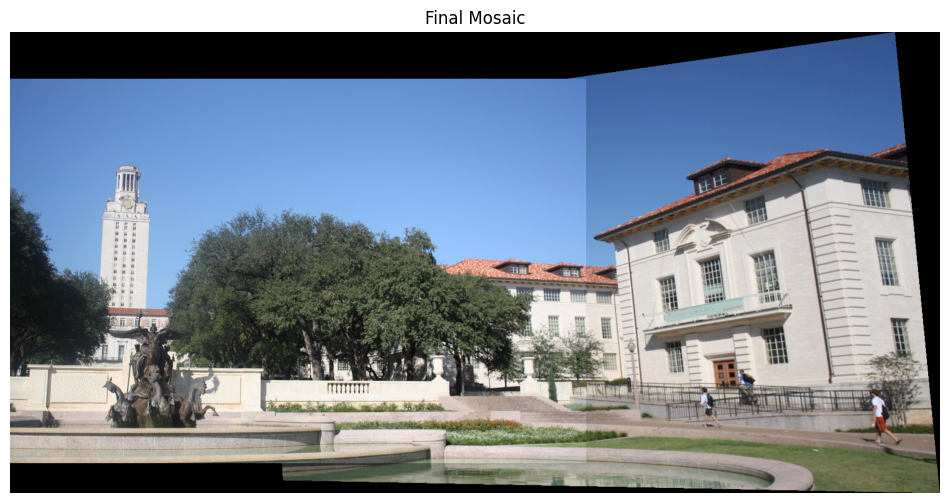

In [794]:
color_img1=cv2.imread('pano_image1.jpg')
color_img2=cv2.imread('pano_image2.jpg')


# mosaic_output = create_image_mosaic(pano_img1, pano_img2, H)
mosaic_output = create_image_mosaic(color_img1, color_img2, H)

def delete_black(image):
    # Deleting black rows
    idy = np.argwhere(np.all(image[..., :] == 0, axis=1))
    image = np.delete(image, idy, axis=0)
    # Deleting black columns
    idx = np.argwhere(np.all(image[..., :] == 0, axis=0))
    image = np.delete(image, idx, axis=1)
    return image

mosaic_output = delete_black(mosaic_output)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(mosaic_output, cv2.COLOR_BGR2RGB) if mosaic_output.ndim == 3 else mosaic_output, cmap='gray')
plt.title("Final Mosaic")
plt.axis("off")
plt.show()
